This exercise aims to remove shadows from text-based images. It comprises of two main steps: shadow detection and shadow removal. We will implement this algorithm as mentioned in the paper to remove shadows while preserving text details.

In [1]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color
from skimage.filters import threshold_otsu

We start by reading in the image. We convert the image if we want to process it as grayscale. If not, we must process each channel separately and concatenate them.

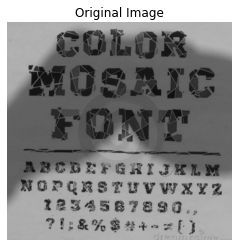

In [2]:
def read_img(filename, isRGB=False):
  img = mpimg.imread(filename)
  if not isRGB: img = color.rgb2gray(img) # convert to grayscale
  plt.axis('off')
  plt.title('Original Image')
  plt.imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
  return img

img = read_img('../dataset/document/color_mosaic.jpg', False)

Now we try to get the local background color, which is the image with just the text removed so we can see the outline of the shadow. For this part, the paper discusses a more extensive approach. 

First, we would find the maximum $I_{max}$ and minimum $I_{min}$ within a window across the whole image: 

$$ I_{max}(x, y) = max(I(i, j)), (i,j) \in W $$
$$ I_{min}(x, y) = min(I(i, j)), (i,j) \in W $$

This would then be used to compute a fusion factor $\alpha$ to correct extreme white noise:

$$ \alpha = (I_{max}(x, y) - I_{min}(x, y)) / I_{max}(x, y) $$

The local background color $L$ can be found as a blending operation of the two:

$$ L(x,y) = I_{max}(x, y) * (1-\alpha) +  I_{min}(x, y) * \alpha $$

The paper mentioned that some residual components might persist in the local background image, so to address this, multiple iterations of the mentioned steps is carried out. Apparently, in practice, three iterations using a 5x5 window achieves good results. 

However, this did not produce good results for us. Instead, we simply set the local background color to the results of the maximum filter, shown below. By choosing the window size of the filter appropriately, we can eliminate the text and capture the full area of the shadow.

$$ L(x,y) = I_{max}(x, y) = max(I(i, j)), (i,j) \in W $$

Different images call for different window sizes. After experimenting with this, we can come to the conclusion that the larger or bolder the text in the image, the bigger the window size for the filter. This makes sense -- in order to remove the text, we need a large enough window that captures the text pixels as well as some pixels of the background. The light-colored pixels of the background will dominate over those near-black text pixels.


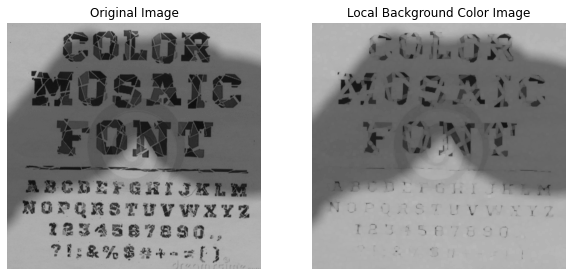

In [3]:
def get_LocalBG(img, kernel_size=5):
  
  L = None
  if len(img.shape) == 3:
    temp_L = []
    for i in range(3):
      Imax = ndimage.maximum_filter(img[:,:,i], size=kernel_size) # apply max filter
      temp_L.append(Imax)
      temp_L[i][temp_L[i] == 0] = 0.000001 # to prevent NaN due to divide by 0
    L = np.stack((temp_L), axis=2)
  else:
    Imax = ndimage.maximum_filter(img, size=kernel_size) # apply max filter
    L = Imax
    L[L == 0] = 0.000001 # to prevent NaN due to divide by 0

  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
  ax1.axis('off')
  ax1.set_title('Original Image')
  ax1.imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
  ax2.axis('off')
  ax2.set_title('Local Background Color Image')
  ax2.imshow(L, cmap=plt.cm.gray, vmin=0, vmax=1)
  return L

L = get_LocalBG(img, 13)

We can retrieve the shadow map by binarizing the image using threshold OTSU. We can see the local background color image and its shadow map, where the shadowed area is in white and the rest in black.

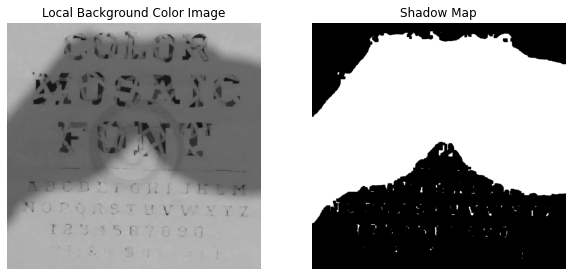

In [4]:
def show_ShadowMap(L):

  shadow_map = None
  if len(L.shape) == 3:
    shadow_maps = []
    for i in range(3):
      thresh = threshold_otsu(L[:,:,i]) # binarize image with thresholding
      temp_shadow_map = L[:,:,i] < thresh
      temp_shadow_map = temp_shadow_map * 1
      shadow_maps.append(temp_shadow_map)
    shadow_map = shadow_maps[0] | shadow_maps[1] | shadow_maps[2]
  else:
    thresh = threshold_otsu(L) # binarize image with thresholding
    shadow_map = L < thresh

  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
  ax1.axis('off')
  ax1.set_title('Local Background Color Image')
  ax1.imshow(L, cmap=plt.cm.gray, vmin=0, vmax=1)
  ax2.axis('off')
  ax2.set_title('Shadow Map')
  ax2.imshow(shadow_map, cmap=plt.cm.gray, vmin=0, vmax=1)

show_ShadowMap(L)

Given the local background color image and shadow map, we can find the global reference background color by finding the average across all pixels within the unshadowed region:

$$ G = \frac{1}{n} \sum L(i, j), (i,j) \in {Unshadowed Region} $$

We can see the unshadowed region and the global background color found from it.

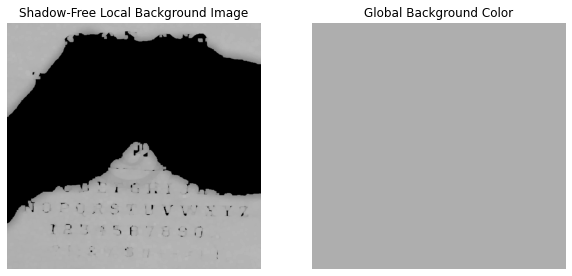

In [5]:
def get_GlobalBG(L):

  unshadow_bg = None
  G = None
  if len(L.shape) == 3:
    unshadow_bgs = []
    for i in range(3):
      thresh = threshold_otsu(L[:,:,i]) # binarize image with thresholding
      unshadowed_area = L[:,:,i] > thresh
      temp_unshadow_bg = L[:,:,i] * unshadowed_area # mask the shadowed areas
      unshadow_bgs.append(temp_unshadow_bg)
      unshadow_bg = np.stack((unshadow_bgs), axis=2)

    for i in range(3):
      unshadow_bgs[i] = unshadow_bgs[i][unshadow_bgs[i] != 0]
      unshadow_bgs[i] = np.mean(unshadow_bgs[i]) # average pixel color
      unshadow_bgs[i] = unshadow_bgs[i] * np.ones(L[:,:,i].shape)
      unshadow_bgs[i] = unshadow_bgs[i].astype(int)
    G = np.stack((unshadow_bgs), axis=2)

  else:
    thresh = threshold_otsu(L) # binarize image with thresholding
    unshadowed_area = L > thresh
    unshadow_bg = L * unshadowed_area # mask the shadowed areas

    temp_unshadow_bg = unshadow_bg[unshadow_bg != 0]
    temp_unshadow_bg = np.mean(temp_unshadow_bg) # average pixel color
    G = temp_unshadow_bg * np.ones(L.shape)

  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
  ax1.axis('off')
  ax1.set_title('Shadow-Free Local Background Image')
  ax1.imshow(unshadow_bg, cmap=plt.cm.gray, vmin=0, vmax=1)
  ax2.axis('off')
  ax2.set_title('Global Background Color')
  ax2.imshow(G, cmap=plt.cm.gray, vmin=0, vmax=1)
  return G

G = get_GlobalBG(L)

Now we can compute the shadow scale $r$ as a function of global background color $G$ and local background color image $L$. The regions obstructed by shadows are generally darker than those without any shadows. We can relight the areas concealed by the shadows by applying the shadow scale. Multiplying the original shadowed image by the shadow scale gives us the final shadow-free image.

$$ r(x,y) = \frac{G}{L(x,y)} $$
$$ final = r(x,y) * img $$

When $r = 1$, it is because $G = L$. $G$ is the color of the unshadowed areas, so the lighter regions. For parts of the image in $L$ where they are shadow-free, $G = L$ and thus $r = 1$. Multiplying the original image by 1 leaves those shadow-free portions unchanged. However, for parts of the image in $L$ that lie within the shadow, $\frac{G}{L}$ will be larger than 1 since the pixels with a lighter color have a higher intensity and pixels with a darker color have a lower intensity. Multiplying the original image by this scalar brightens those shadowed areas to match the color of the global background.

The paper metioned recalculating the local background color $L$ using a 3x3 window but since that did not yield any significant change, we left $L$ as the value which was initially computed.

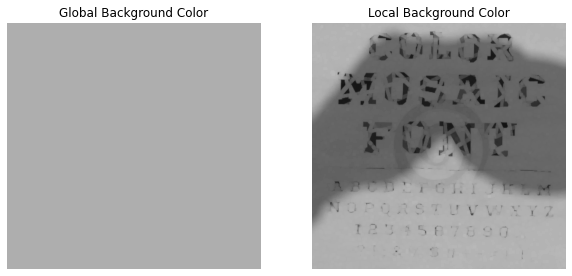

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.axis('off')
ax1.set_title('Global Background Color')
ax1.imshow(G, cmap=plt.cm.gray, vmin=0, vmax=1)
ax2.axis('off')
ax2.set_title('Local Background Color')
ax2.imshow(L, cmap=plt.cm.gray, vmin=0, vmax=1)

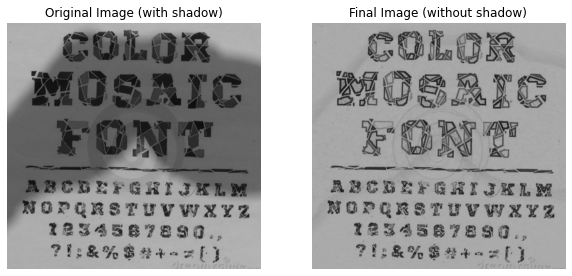

In [7]:
def get_FinalImg(img, L, G):

  r = G/L # find shadow scale
  final = r * img # relight shadow regions
  if len(img.shape) == 3: final = final.astype(int)

  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
  ax1.axis('off')
  ax1.set_title('Original Image (with shadow)')
  ax1.imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
  ax2.axis('off')
  ax2.set_title('Final Image (without shadow)')
  ax2.imshow(final, cmap=plt.cm.gray, vmin=0, vmax=1)
  return final

final = get_FinalImg(img, L, G)

When the illumination is non-uniform, we may see some slight artifacts. The paper suggested a method to fix this, called tone fine-tuning. It makes use of a tone scale, which is a ratio between shadowed and unshadowed regions:

$$ \tau = \frac{unshadowed}{shadowed}$$

`unshadowed` is the average background color of unshadowed regions and `shadowed` is the average background color of shadowed regions. Thus, tone scale $\tau$ is a scale between bright and dark regions and applying it on the final image can produce a better removal of shadow.

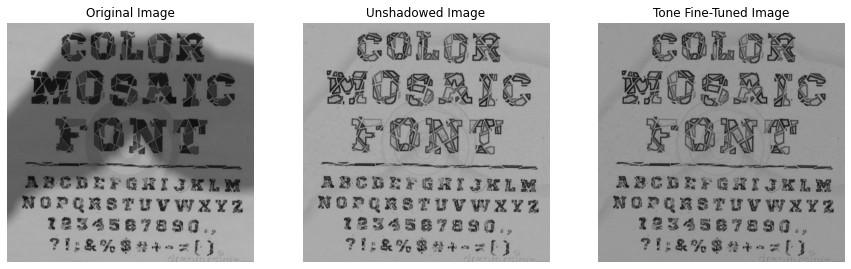

In [8]:
def fineTune(img, L, G, final):

  thresh = threshold_otsu(L) # binarize image with thresholding
  shadow_map = L < thresh
  shadow_bg = L * shadow_map # mask the unshadowed areas
  shadow_bg = shadow_bg[shadow_bg != 0]
  shadow_bg = np.mean(shadow_bg) # average pixel color
  shadow_bg = shadow_bg * np.ones(L.shape)

  tau = (G/shadow_bg) * 0.5 # find tone scale
  tuned = final * tau # apply tone scale
  if len(img.shape) == 3: tuned = tuned.astype(int)

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8))
  ax1.axis('off')
  ax1.set_title('Original Image')
  ax1.imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
  ax2.axis('off')
  ax2.set_title('Unshadowed Image')
  ax2.imshow(final, cmap=plt.cm.gray, vmin=0, vmax=1)
  ax3.axis('off')
  ax3.set_title('Tone Fine-Tuned Image')
  ax3.imshow(tuned, cmap=plt.cm.gray, vmin=0, vmax=1)
    
fineTune(img, L, G, final)

As we can see here, the effects of tone fine-tuning are negligible. It was not as helpful for us as the paper mentioned.

The following function is a consolidation of  all the methods listed above.

In [9]:
def removeShadow(filename, isRGB, kernel_size):
  img = read_img(filename, isRGB) # read in image
  L = get_LocalBG(img, kernel_size) # get the local background color
  show_ShadowMap(L) # get the shadow map
  G = get_GlobalBG(L) # get the global background color
  final = get_FinalImg(img, L, G) # show the input vs output
  fineTune(img, L, G, final) # show effects of tuning

Let's run this on some images, both RGB and grayscale.

/var/folders/ky/9twm3ccd79sddch2zj3_bfjc0000gn/T/ipykernel_4871/942474333.py:3: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (1164, 1200, 3) looks like that of an RGB image.
  thresh = threshold_otsu(L) # binarize image with thresholding


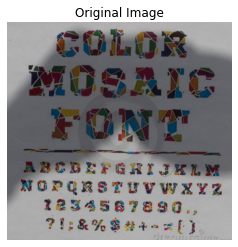

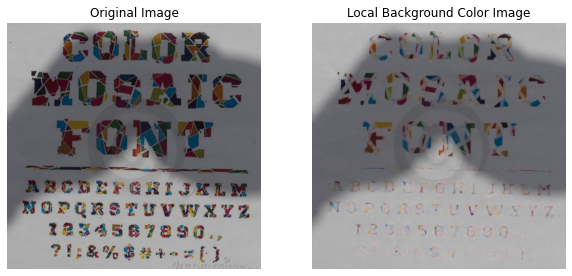

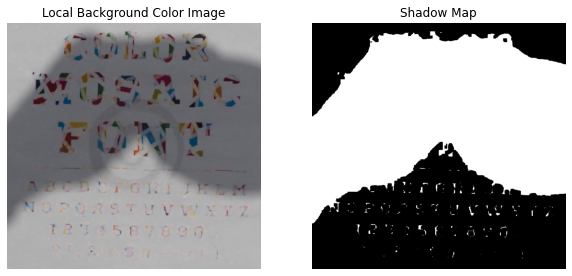

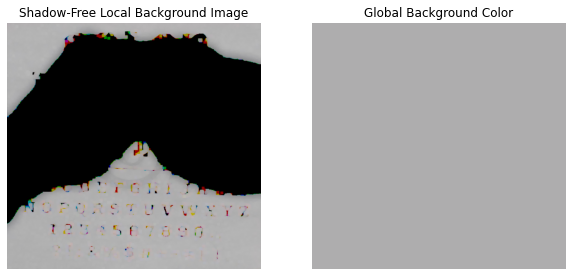

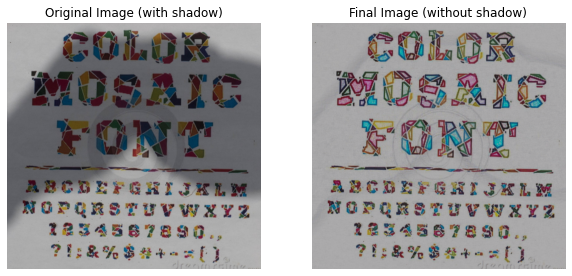

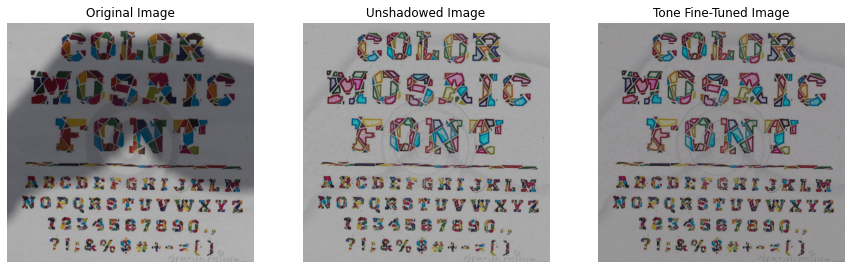

In [10]:
removeShadow('../dataset/document/color_mosaic.jpg', True, 13)

/var/folders/ky/9twm3ccd79sddch2zj3_bfjc0000gn/T/ipykernel_4871/942474333.py:3: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (371, 556, 3) looks like that of an RGB image.
  thresh = threshold_otsu(L) # binarize image with thresholding
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


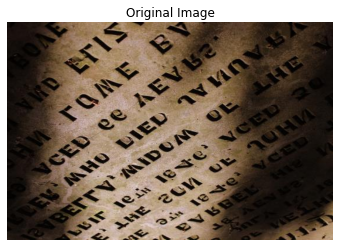

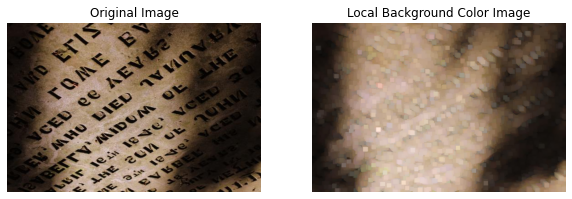

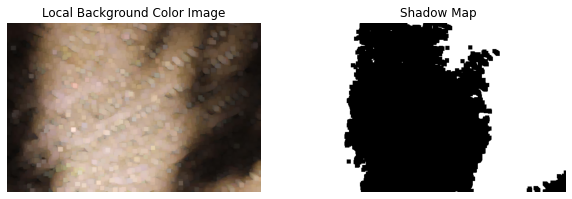

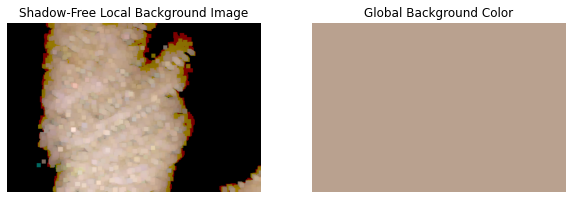

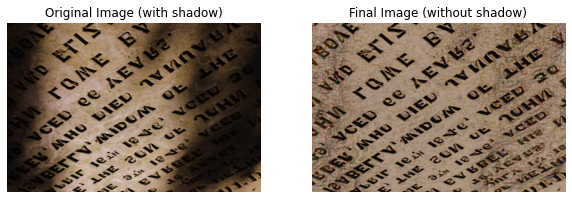

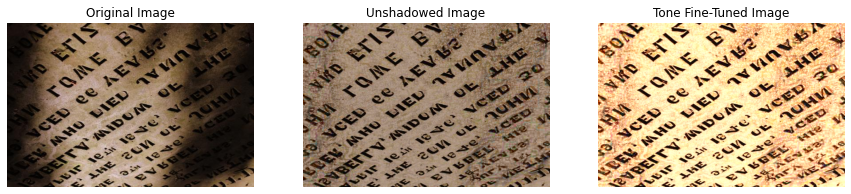

In [11]:
removeShadow('../dataset/document/manuscript.jpg', True, 9)

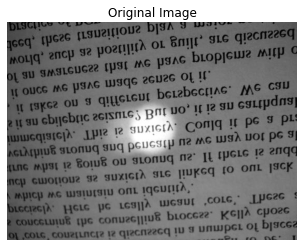

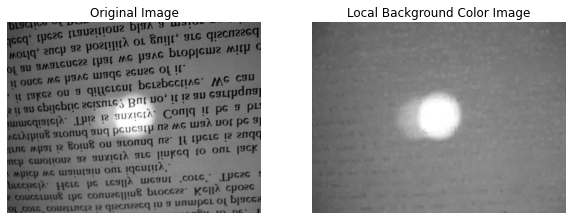

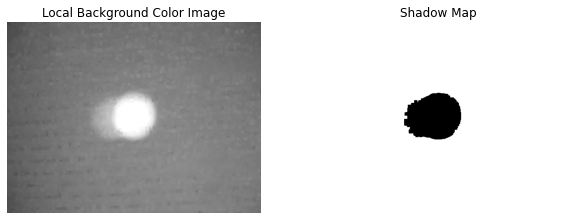

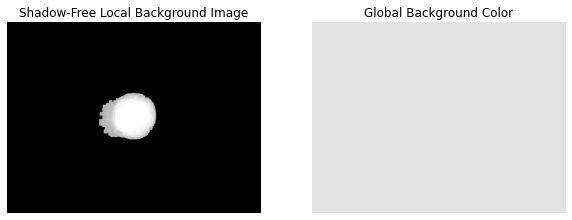

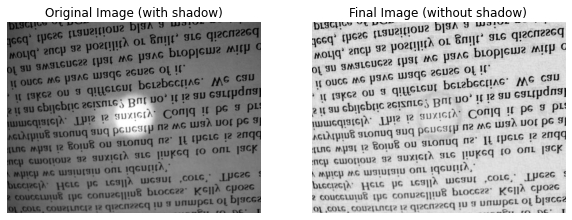

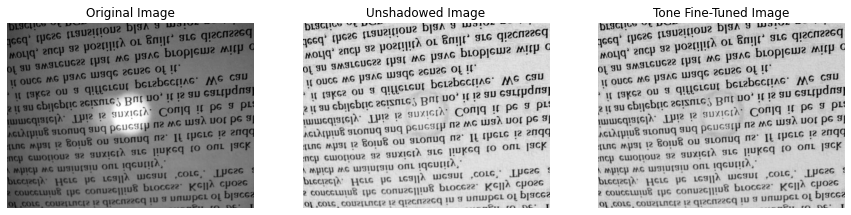

In [12]:
removeShadow('../dataset/document/textbook.jpg', False, 7)

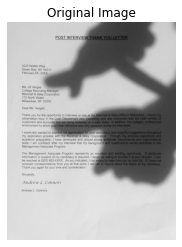

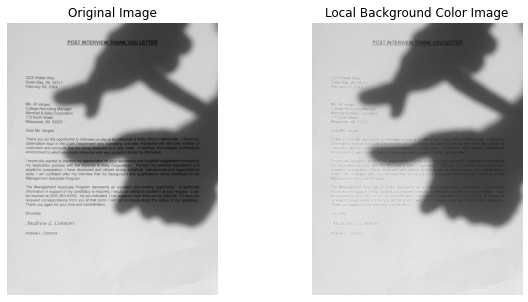

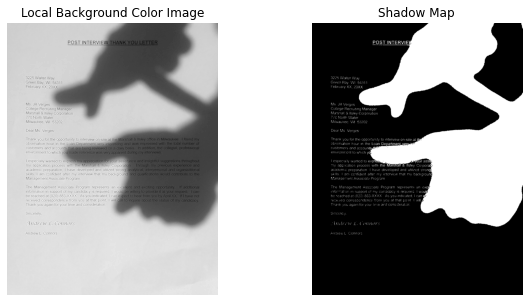

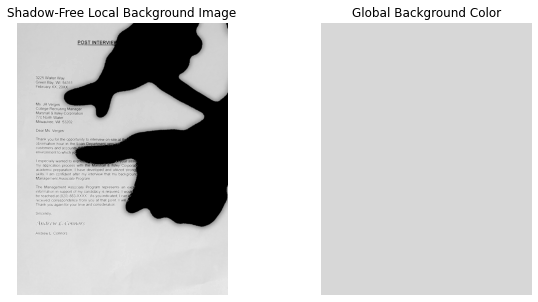

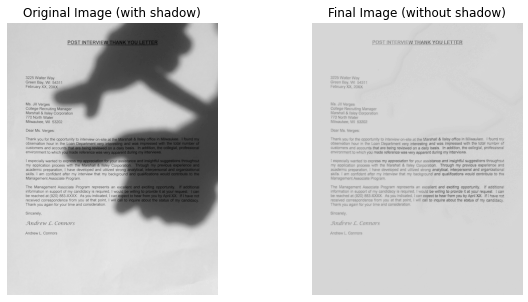

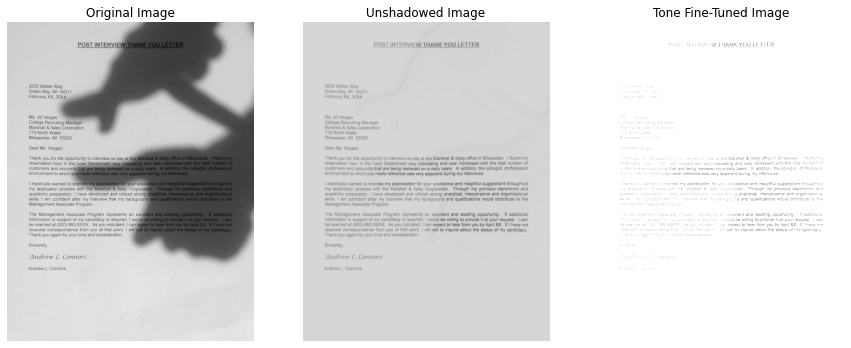

In [13]:
removeShadow('../dataset/document/document.png', False, 2)

This exercise worked to remove shadows from text-based images. To extend this application further, we could apply it to natural images, although this exact approach may not work. Natural scenes contain many more colors, textures, light sources, and other complexities that would require an extensive algorithm.